In [1]:
import pandas as pd
from IPython.core.display import display, HTML
import matplotlib.pyplot as plt
import os
from os.path import join as pjoin
import numpy as np
import pandas as pd
from time import time, sleep, strftime, localtime
from datetime import datetime

%reload_ext autoreload
%autoreload 1

pd.set_option('display.max_rows', 800)
pd.set_option('display.max_columns', 100)
pd.set_option('display.width', 100)
pd.set_option('display.max_colwidth', 500)

display(HTML("<style>.container { width:100% !important; }</style>"))

import warnings
warnings.filterwarnings('ignore')

In [2]:
import re, string
import requests
from bs4 import BeautifulSoup
from itertools import groupby
import seaborn as sns
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer
import matplotlib.pyplot as plt
from sklearn.feature_extraction import text 

from wordcloud import WordCloud

from Utils.UtilsViz import *
from Utils.DataUtils import *

In [3]:
data_path = "./data"
os.listdir(data_path)
train_set = pd.read_csv(pjoin(data_path, 'train.csv'))
test_set = pd.read_csv(pjoin(data_path, 'test.csv'))

In [4]:
train_set_ori = train_set.copy()

In [5]:
display(
    train_set.shape,
    train_set.head()
)

(7613, 5)

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake May ALLAH Forgive us all,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are being notified by officers. No other evacuation or shelter in place orders are expected,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation orders in California",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as smoke from #wildfires pours into a school,1


In [6]:
analyse_nans(train_set)

,id,keyword,location,text,target
total,0,61,2533,0,0
percentage,0,0.8,33.3,0,0
idx_list,[],"[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 7583, 7584, 7585, 7586, 7587, 7588, 7589, 7590, 7591, 7592, 7593, 7594, 7595, 7596, 7597, 7598, 7599, 7600, 7601, 7602, 7603, 7604, 7605, 7606, 7607, 7608, 7609, 7610, 7611, 7612]","[0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 38, 41, 43, 44, 45, 47, 60, 75, 80, 82, 85, 90, 92, 99, 110, 112, 116, 122, 123, 130, 131, 132, 135, 140, 147, 152, 156, 159, 164, 171, 174, 177, 182, 185, 187, 190, 196, 198, 202, 205, 206, 213, 214, 215, 219, 220, 222, 224, 225, 229, 231, 234, 236, 238, 240, 244, 245, 246, 250, 253, 256, 257, 261, 262, 267, 268, 274, 275, 279, ...]",[],[]


Much cleaner than msot datasets, to be fair.

Class distributions

In [7]:
train_set["target"].value_counts()

0    4342
1    3271
Name: target, dtype: int64

Fairly close. Can definitely work with this.

#  Text cleaning

1. Lowercase text
1. Remove special unrendered words
1. Remove hyperlinks
1. Remove non alphabets
1. remove stop words
1. Lemmatization

In [8]:
# Lowercase text
train_set["text"] = train_set["text"].apply(str.lower)

In [9]:
# Remove special unrendered words
# Example - & is represented as "&amp"
special_words = ["&amp;"]

def remove_specialwords(x):
    clean_str = [word for word in x.split(' ') if not any(spword in word for spword in special_words)]
    return ' '.join(clean_str)

train_set["text"] = train_set["text"].apply(remove_specialwords)

In [10]:
# Remove hyperlinks
def remove_urls(x):
    clean_str = [word for word in x.split(' ') if "http" not in word]
    return ' '.join(clean_str)

train_set["text"] = train_set["text"].apply(remove_urls)

In [11]:
# Remove non-alphabets
train_set["text"] = train_set["text"].apply(lambda x: re.sub('[^a-zA-Z ]', '', x))

In [12]:
# Remove stop words
stop_words = text.ENGLISH_STOP_WORDS

def remove_stopwords(x):
    clean_str = [word for word in x.split(' ') if word not in stop_words]
    return ' '.join(clean_str)

train_set['text'] = train_set['text'].apply(remove_stopwords)

In [13]:
# Lemmatize the words
wordnet_lemmatizer = WordNetLemmatizer()

def lemmatize_words(x):
    clean_str = [wordnet_lemmatizer.lemmatize(word, pos="v") for word in x.split(' ')]
    return ' '.join(clean_str)

train_set['text'] = train_set['text'].apply(lemmatize_words)

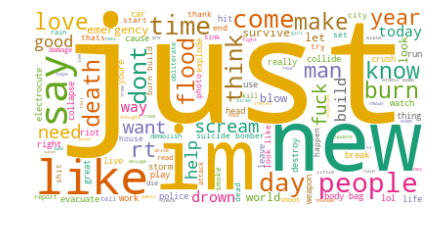

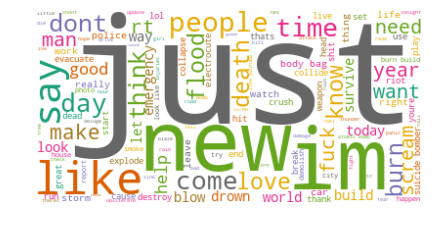

In [19]:
# Reset the output dimensions
wc = WordCloud(stopwords=stop_words, background_color="white", colormap="Dark2",
               max_font_size=150, random_state=42)

def plot_wordcloud(text, wc, figsize=[7,7]):
    plt.rcParams['figure.figsize'] = [7, 7]

    wc.generate(' '.join(train_set["text"].values))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title("")

    plt.show()
    
    
q1 = "target==1"
t1 = ' '.join(train_set.query(q1)["text"].values)
plot_wordcloud(t1, wc)

q2 = "target==0"
t2 = ' '.join(train_set.query(q2)["text"].values)
plot_wordcloud(t2, wc)

We need to remove additional words that are polluting the wordcloud

In [ ]:
# Find the most frequently occuring words for each 